In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[9], 'GPU')
            device = '/gpu:9'
    except RuntimeError as e:
        print(e)

print("device", device)


2024-08-18 17:12:49.326353: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-18 17:12:49.340857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 17:12:49.354090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 17:12:49.358081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 17:12:49.370100: I tensorflow/core/platform/cpu_feature_guar

device /gpu:9


Load the data

In [2]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt

# Load HDF5 data
h5_filename = '/home/da886/ElectronCountingProject/Small Building Blocks/Data Generated/100K_3electronsOnlyImages_smaller_negative_paddings.h5'
with h5py.File(h5_filename, 'r') as f:
    images = np.array(f['images'])
    centers = np.array(f['centers_training'])


### raw image with box locations

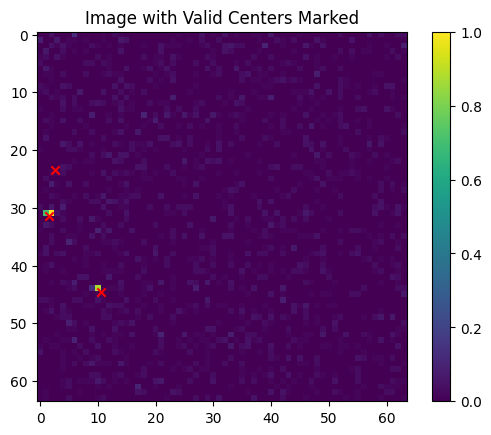

In [3]:
a = np.random.randint(0, len(images))
# a =2
image = images[a]
centerss = centers[a]

# Plot the image with valid centers
plt.imshow(image, )
valid_centers = centerss[centerss[:, 0] == 1]
for center in valid_centers:
    plt.scatter(center[1], center[2], c='red', marker='x')  # Note: center[1] is x and center[2] is y
plt.title('Image with Valid Centers Marked')
plt.colorbar()
plt.show()


Sort the boxes locations in ascending order(top left to bottom right)

In [4]:


# Function to sort centers from top-left to bottom-right
def sort_centers(centers):
    # Sort by y first, then by x
    return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

# Sort the centers for each image
sorted_centers = np.array([sort_centers(image_centers[:, 1:]) for image_centers in centers])


Example of sorted centers/midpoints

In [5]:
k = np.random.randint(0,len(sorted_centers))
sorted_centers[k],centers[k]

(array([[54.5, 14.5],
        [33.5, 25.5],
        [25.5, 30.5]], dtype=float32),
 array([[ 1. , 33.5, 25.5],
        [ 1. , 54.5, 14.5],
        [ 1. , 25.5, 30.5]], dtype=float32))

'Orange is y value'

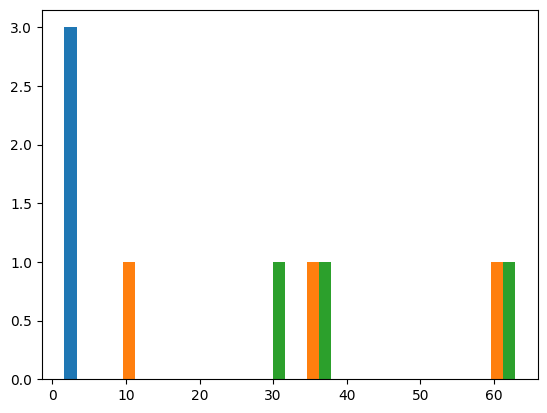

In [20]:
e = np.random.randint(0, len(centers))
# e= 2
plt.hist(centers[e])

"""Y axis is frequency: X axis is coordinate(value)"""
"""Blue is probability value"""
"""Green is x value"""
"""Orange is y value"""

In [21]:
#### Statistics of the images
np.max(images), np.min(images), np.mean(images), np.std(images)

(255, 0, 0.6709496899414062, 3.9189994048666192)

In [22]:
np.max(centers), np.min(centers)

(63.5, 1.0)

## Normalized Data

In [6]:

normalized_images = (images+1e-9)/9.26
normalized_centers = sorted_centers / [64, 64]
normalized_midpoints =normalized_centers
normalized_probabilities = centers[:, :, :1] / 64
normalized_midpoints = tf.expand_dims(normalized_midpoints,axis=1)
normalized_probabilities = tf.expand_dims(normalized_probabilities,axis =1)

2024-08-18 17:13:07.941351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 9, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:cf:00.0, compute capability: 8.0


Range for the inputs

In [25]:
np.max(normalized_images), np.min(normalized_images)

(27.53779697634989, 1.0799136069114472e-10)

Range for the outputs

In [26]:
np.max(normalized_centers), np.min(normalized_centers)

(0.9921875, 0.0234375)

In [29]:
normalized_images.shape, normalized_midpoints.shape, normalized_probabilities.shape

((100000, 64, 64),
 TensorShape([100000, 1, 3, 2]),
 TensorShape([100000, 1, 3, 1]))

In [30]:
normalized_centers[3],centers[3]

(array([[0.9609375, 0.0703125],
        [0.1328125, 0.5703125],
        [0.4140625, 0.9609375]]),
 array([[ 1. ,  8.5, 36.5],
        [ 1. , 61.5,  4.5],
        [ 1. , 26.5, 61.5]], dtype=float32))

In [16]:
normalized_probabilities 

<tf.Tensor: shape=(100000, 1, 3, 1), dtype=float32, numpy=
array([[[[0.015625],
         [0.015625],
         [0.015625]]],


       [[[0.015625],
         [0.015625],
         [0.015625]]],


       [[[0.015625],
         [0.015625],
         [0.015625]]],


       ...,


       [[[0.015625],
         [0.015625],
         [0.015625]]],


       [[[0.015625],
         [0.015625],
         [0.015625]]],


       [[[0.015625],
         [0.015625],
         [0.015625]]]], dtype=float32)>

In [16]:
normalized_midpoints 

<tf.Tensor: shape=(50000, 1, 3, 2), dtype=float64, numpy=
array([[[[0.6328125, 0.1953125],
         [0.1015625, 0.5078125],
         [0.8359375, 0.7734375]]],


       [[[0.9296875, 0.0234375],
         [0.3203125, 0.1484375],
         [0.6640625, 0.7890625]]],


       [[[0.0390625, 0.0234375],
         [0.5234375, 0.2421875],
         [0.6796875, 0.4609375]]],


       ...,


       [[[0.8671875, 0.5078125],
         [0.8828125, 0.8203125],
         [0.8515625, 0.8984375]]],


       [[[0.9609375, 0.4921875],
         [0.4140625, 0.5703125],
         [0.5859375, 0.8984375]]],


       [[[0.3515625, 0.2421875],
         [0.6328125, 0.3671875],
         [0.9609375, 0.4765625]]]])>

In [7]:

split_idx = int(0.8 * len(normalized_images))
train_images, val_images = normalized_images[:split_idx], normalized_images[split_idx:]
train_midpoints, val_midpoints = normalized_midpoints[:split_idx], normalized_midpoints[split_idx:]
train_probabilities, val_probabilities = normalized_probabilities[:split_idx], normalized_probabilities[split_idx:]
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, {'x_probabilities_reshape':train_probabilities,'x_midpoints_reshape':train_midpoints}))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, {'x_probabilities_reshape':val_probabilities,'x_midpoints_reshape':val_midpoints,}))

In [8]:
batch_size = 2000
train_dataset = train_dataset.shuffle(buffer_size=4000,reshuffle_each_iteration= True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=4000).batch(batch_size)

In [34]:
train_images

array([[[1.07991361e-10, 1.07991361e-10, 1.07991361e-10, ...,
         1.07991361e-10, 1.07991361e-10, 1.07991361e-10],
        [1.07991361e-10, 1.07991361e-10, 1.07991361e-10, ...,
         1.07991361e-10, 1.07991361e-10, 1.07991361e-10],
        [1.07991361e-10, 1.07991361e-10, 1.07991361e-10, ...,
         1.07991361e-10, 1.07991361e-01, 1.07991361e-10],
        ...,
        [1.07991361e-10, 1.07991361e-01, 1.07991361e-10, ...,
         1.07991361e-10, 1.07991361e-10, 1.07991361e-10],
        [1.07991361e-10, 3.23974082e-01, 1.07991361e-10, ...,
         1.07991361e-01, 1.07991361e-10, 1.07991361e-10],
        [1.07991361e-10, 1.07991361e-10, 1.07991361e-01, ...,
         1.07991361e-10, 1.07991361e-01, 1.07991361e-10]],

       [[1.07991361e-10, 1.07991361e-01, 1.07991361e-10, ...,
         1.07991361e-10, 1.07991361e-01, 1.07991361e-10],
        [1.07991361e-10, 1.07991361e-10, 4.31965443e-01, ...,
         1.07991361e-01, 1.07991361e-01, 1.07991361e-10],
        [1.07991361e-10, 

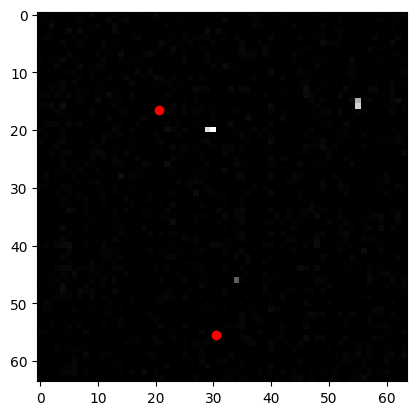

In [147]:
# train_images,train_targets = next(iter(train_dataset))
# # print(train_images.shape, train_targets['x_midpoints_reshape'].shape)
# # plt.imshow(train_images[0], cmap='gray')
# import matplotlib.pyplot as plt

# # Extract the first image and its corresponding midpoints
# image = train_images[0]
# midpoints = train_targets['x_midpoints_reshape'][0] # Convert to numpy if it's a tensor

# # Plot the image
# plt.imshow(image, cmap='gray')

# # Plot the midpoints
# # Midpoints are normalized, so multiply by the image size (64x64 in this case)
# img_size = 64
# x_coords = midpoints[:, 1] * img_size
# y_coords = midpoints[:, 0] * img_size

# # Plot the midpoints
# plt.scatter(x_coords, y_coords, color='red')

# # Display the plot without inverting the y-axis
# plt.show()



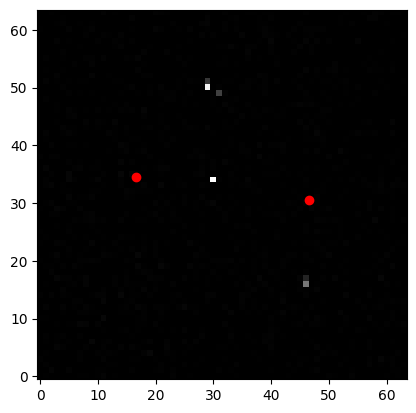

In [96]:
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(image, cmap='gray')

# Plot the midpoints
plt.scatter(x_coords, y_coords, color='red')

# Invert the y-axis to match the image's coordinate system
plt.gca().invert_yaxis()

# Display the plot
plt.show()


In [23]:
train_midpoints

<tf.Tensor: shape=(80000, 1, 3, 2), dtype=float64, numpy=
array([[[[0.1484375, 0.1171875],
         [0.1171875, 0.2265625],
         [0.3515625, 0.6171875]]],


       [[[0.5078125, 0.0234375],
         [0.2421875, 0.1640625],
         [0.1328125, 0.8828125]]],


       [[[0.4140625, 0.0234375],
         [0.7890625, 0.1484375],
         [0.7890625, 0.1640625]]],


       ...,


       [[[0.0703125, 0.5234375],
         [0.5390625, 0.7421875],
         [0.8671875, 0.8046875]]],


       [[[0.4140625, 0.3203125],
         [0.1484375, 0.8828125],
         [0.3984375, 0.8828125]]],


       [[[0.1640625, 0.3046875],
         [0.5546875, 0.4453125],
         [0.6796875, 0.8359375]]]])>

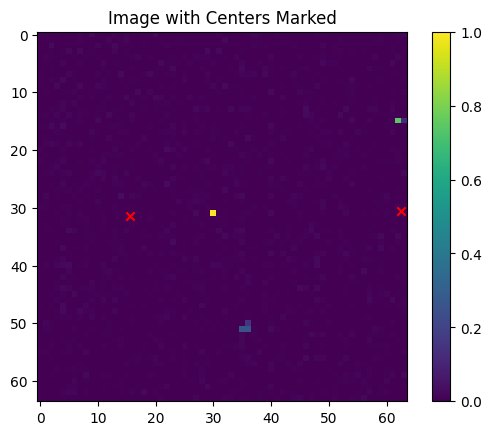

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Select a random image and corresponding centers
o = np.random.randint(0, len(val_images))
# o=2
imagess = val_images[o]
centersss = val_midpoints[o]*[64,64]

# Plot the image with centers
plt.imshow(imagess)

# Assuming centerss[:, 0] is x and centerss[:, 1] is y
for center in centersss:
    plt.scatter(center[0], center[1], c='red', marker='x')  # center[0] is x and center[1] is y

plt.title('Image with Centers Marked')
plt.colorbar()
plt.show()






In [19]:
val_midpoints[2]

<tf.Tensor: shape=(1, 3, 2), dtype=float64, numpy=
array([[[0.6953125, 0.5078125],
        [0.1171875, 0.6640625],
        [0.3046875, 0.9140625]]])>

In [15]:
train_dataset, val_dataset 

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(64, 64), dtype=tf.float64, name=None), {'x_probabilities_reshape': TensorSpec(shape=(1, 3, 1), dtype=tf.float32, name=None), 'x_midpoints_reshape': TensorSpec(shape=(1, 3, 2), dtype=tf.float64, name=None)})>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(64, 64), dtype=tf.float64, name=None), {'x_probabilities_reshape': TensorSpec(shape=(1, 3, 1), dtype=tf.float32, name=None), 'x_midpoints_reshape': TensorSpec(shape=(1, 3, 2), dtype=tf.float64, name=None)})>)

In [7]:
train_dataset, val_dataset 

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64), dtype=tf.float64, name=None), {'x_probabilities_reshape': TensorSpec(shape=(None, 1, 3, 1), dtype=tf.float32, name=None), 'x_midpoints_reshape': TensorSpec(shape=(None, 1, 3, 2), dtype=tf.float64, name=None)})>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64), dtype=tf.float64, name=None), {'x_probabilities_reshape': TensorSpec(shape=(None, 1, 3, 1), dtype=tf.float32, name=None), 'x_midpoints_reshape': TensorSpec(shape=(None, 1, 3, 2), dtype=tf.float64, name=None)})>)

In [9]:
print(f"train_images shape is",train_images.shape) 
print(f"train_midpoints shape is",train_midpoints.shape)
print(f"train_probabilities shape is",train_probabilities.shape)

train_images shape is (80000, 64, 64)
train_midpoints shape is (80000, 1, 3, 2)
train_probabilities shape is (80000, 1, 3, 1)


In [10]:
print(f"val_images shape is",val_images.shape) 
print(f"val_midpoints shape is",val_midpoints.shape)
print(f"val_probabilities shape is",val_probabilities.shape)

val_images shape is (20000, 64, 64)
val_midpoints shape is (20000, 1, 3, 2)
val_probabilities shape is (20000, 1, 3, 1)


### Sample image with midpoints

for better analysis, the index has been set to a specific example: 2 in this case

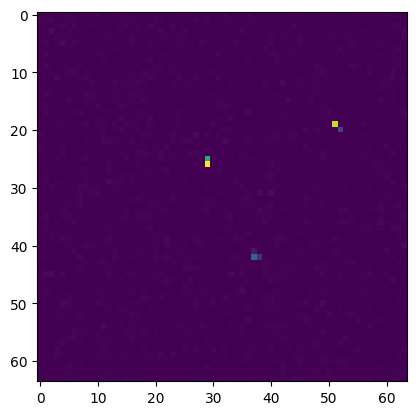

In [111]:
f = np.random.randint(0, len(train_images))
# f = 2
plt.imshow(train_images[f])

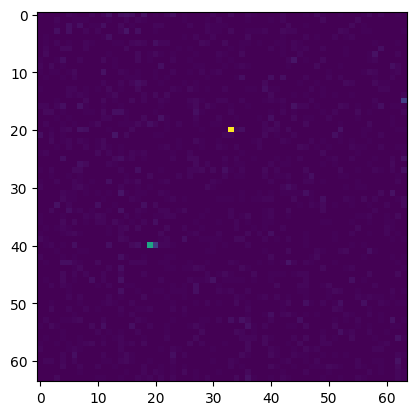

In [106]:
g = np.random.randint(0, len(val_images))
# g = 2
plt.imshow(val_images[g])

In [112]:
# h = np.random.randint(0, len(normalized_images))
h = 2
normalized_images[f],normalized_centers[f]

(array([[1.07991361e-10, 1.07991361e-10, 1.07991361e-10, ...,
         2.15982721e-01, 1.07991361e-01, 1.07991361e-10],
        [2.15982721e-01, 2.15982721e-01, 4.31965443e-01, ...,
         1.07991361e-10, 1.07991361e-10, 1.07991361e-10],
        [1.07991361e-10, 1.07991361e-10, 1.07991361e-10, ...,
         2.15982721e-01, 3.23974082e-01, 1.07991361e-10],
        ...,
        [1.07991361e-10, 1.07991361e-10, 1.07991361e-10, ...,
         1.07991361e-10, 1.07991361e-10, 1.07991361e-01],
        [1.07991361e-10, 1.07991361e-10, 1.07991361e-01, ...,
         2.15982721e-01, 1.07991361e-01, 2.15982721e-01],
        [1.07991361e-10, 1.07991361e-10, 1.07991361e-10, ...,
         1.07991361e-10, 1.07991361e-01, 1.07991361e-10]]),
 array([[1.       , 0.8046875, 0.3046875],
        [1.       , 0.5859375, 0.6484375],
        [1.       , 0.4609375, 0.4140625]]))

In [149]:
j = np.array(normalized_midpoints.squeeze())

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'squeeze'

In [144]:
normalized_midpoints.shape

TensorShape([100000, 1, 3, 2])

(array([[0., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 1.]]),
 array([0.1015625, 0.1875   , 0.2734375, 0.359375 , 0.4453125, 0.53125  ,
        0.6171875, 0.703125 , 0.7890625, 0.875    , 0.9609375]),
 <a list of 2 BarContainer objects>)

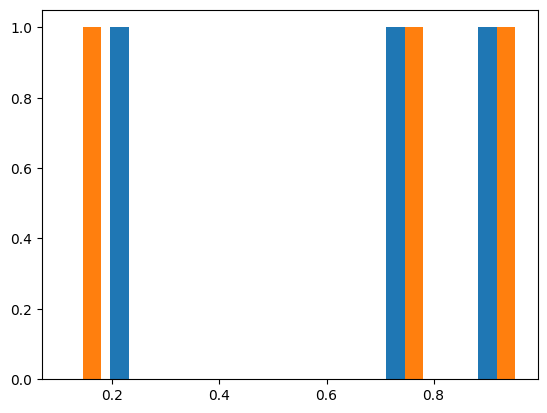

In [12]:
q = np.random.randint(0,len(normalized_midpoints))
plt.hist(normalized_centers[q])

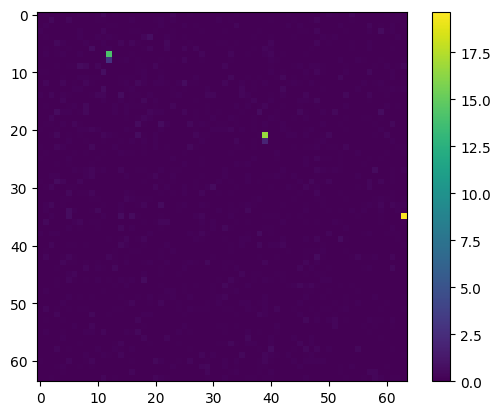

In [123]:
# i = np.random.randint(0, len(normalized_images))
i=2
plt.imshow(normalized_images[i])
plt.colorbar()

(array([7.636234e+06, 5.222330e+05, 1.525800e+04, 8.840000e+02,
        2.290000e+02, 3.960000e+02, 2.720000e+02, 4.120000e+02,
        3.040000e+02, 3.770000e+02, 4.090000e+02, 2.760000e+02,
        4.440000e+02, 2.730000e+02, 4.950000e+02, 3.020000e+02,
        4.650000e+02, 3.220000e+02, 5.090000e+02, 3.530000e+02,
        4.900000e+02, 4.380000e+02, 3.310000e+02, 3.990000e+02,
        2.570000e+02, 3.810000e+02, 1.980000e+02, 3.600000e+02,
        2.170000e+02, 2.990000e+02, 2.890000e+02, 1.790000e+02,
        2.840000e+02, 1.770000e+02, 2.780000e+02, 1.880000e+02,
        2.710000e+02, 1.920000e+02, 2.550000e+02, 1.830000e+02,
        2.340000e+02, 2.220000e+02, 1.680000e+02, 2.260000e+02,
        1.560000e+02, 2.410000e+02, 1.400000e+02, 2.070000e+02,
        1.300000e+02, 1.930000e+02, 1.630000e+02, 1.150000e+02,
        1.900000e+02, 1.170000e+02, 1.930000e+02, 1.220000e+02,
        1.350000e+02, 9.300000e+01, 1.390000e+02, 9.600000e+01,
        1.210000e+02, 1.110000e+02, 8.20

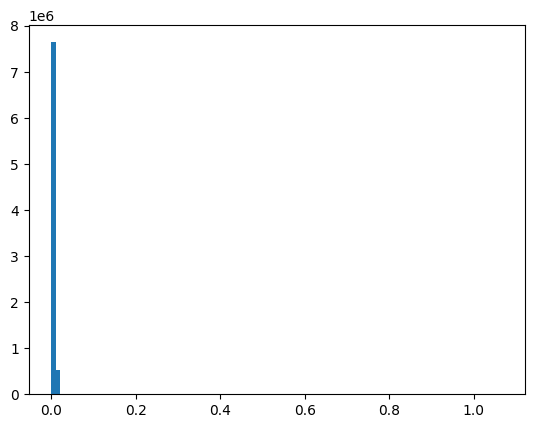

In [37]:
j = np.random.randint(0, len(normalized_images))
# j=2
plt.hist(normalized_images[:2000].flatten(),bins=100)

In [163]:
k = np.random.randint(0, len(normalized_midpoints))
# k =2
# normalized_centers[k], normalized_probabilities[k],normalized_midpoints[k]
normalized_centers

array([[[0.1484375, 0.1171875],
        [0.1171875, 0.2265625],
        [0.3515625, 0.6171875]],

       [[0.5078125, 0.0234375],
        [0.2421875, 0.1640625],
        [0.1328125, 0.8828125]],

       [[0.4140625, 0.0234375],
        [0.7890625, 0.1484375],
        [0.7890625, 0.1640625]],

       ...,

       [[0.9140625, 0.1484375],
        [0.1015625, 0.5546875],
        [0.8671875, 0.9140625]],

       [[0.4609375, 0.3203125],
        [0.8984375, 0.3671875],
        [0.7734375, 0.5859375]],

       [[0.5234375, 0.0234375],
        [0.6171875, 0.0390625],
        [0.1171875, 0.5703125]]])

In [13]:
from tensorflow.keras import layers


input_shape = (64, 64,1)
num_classes = 3
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x) 


x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x) 

x = layers.GlobalAveragePooling2D()(x)



x_prob = layers.Dense(num_classes,activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes,1), name='x_probabilities_reshape')(x_prob)

x_midpoints = layers.Dense(num_classes * num_coordinates,activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input,[x_prob_reshape,x_midpoints_reshape])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3) 



In [14]:
import tensorflow as tf

def custom_mse(y_true, y_pred):
    # Ensuring both tensors are of dtype float64 for higher precision
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    return tf.reduce_mean(tf.square(y_true - y_pred))



def custom_binary_crossentropy(y_true, y_pred):
    # Ensuring both tensors are of dtype float64 for higher precision
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    # Calculate binary crossentropy
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred)



In [15]:
# model.compile(optimizer=optimizer, loss={'x_probabilities_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_midpoints_reshape':tf.keras.losses.MeanSquaredError()})
model.compile(
    optimizer=optimizer, 
    loss={
        'x_probabilities_reshape': custom_binary_crossentropy, 
        'x_midpoints_reshape': custom_mse
    }
)




In [16]:
val_images.shape,val_probabilities.shape,val_midpoints.shape

((20000, 64, 64), TensorShape([20000, 1, 3, 1]), TensorShape([20000, 1, 3, 2]))

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      2,560 │ input_layer[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │      1,024 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    295,040 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    295,168 │ dropout[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 256) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │    147,520 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 4, 64)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 32)  │     18,464 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 2, 2, 32)  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 32)  │        128 │ max_pooling2d_4[

 Total params: 761,993 (2.91 MB)

 Trainable params: 760,521 (2.90 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [18]:
from tensorflow.keras import layers, callbacks
# Custom callback to save the model every 10 epochs
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")

save_freq = 200  # Save every 10 epochs
save_path = "/home/da886/ElectronCountingProject/Small Building Blocks/Weights from recommendations/customlossmodel_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=save_freq, save_path=save_path)

# Define the ReduceLROnPlateau callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',       # Monitor the validation loss
    factor=0.5,               # Factor by which the learning rate will be reduced
    patience=5,               # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,                # Verbosity mode, 1: output logs
    mode='min',               # Min mode, as we want to reduce the LR when the monitored quantity stops decreasing
    min_lr=3e-10               # Lower bound on the learning rate
)

In [19]:
# history = model.fit(train_dataset, epochs=2000, validation_data=val_dataset,callbacks=[checkpoint_callback])
history = model.fit(train_dataset, epochs=1500, validation_data=val_dataset,callbacks=[lr_scheduler])

Epoch 1/1500


I0000 00:00:1724001408.085495 2974880 service.cc:146] XLA service 0x7f2490002a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724001408.085563 2974880 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-18 17:16:48.147480: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-18 17:16:48.375709: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-18 17:16:48.630573: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility pa

 1/40 ━━━━━━━━━━━━━━━━━━━━ 21:56 34s/step - loss: 0.8627

I0000 00:00:1724001440.012570 2974880 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.8639

2024-08-18 17:17:28.834408: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 63.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 318ms/step - loss: 0.8638 - val_loss: 0.8614 - learning_rate: 0.0010
Epoch 2/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.8517 - val_loss: 0.9011 - learning_rate: 0.0010
Epoch 3/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 0.8378 - val_loss: 0.9062 - learning_rate: 0.0010
Epoch 4/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.8272 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 5/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - loss: 0.8151 - val_loss: 0.8712 - learning_rate: 0.0010
Epoch 6/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 0.8052 - val_loss: 0.8470 - learning_rate: 0.0010
Epoch 7/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.7957 - val_loss: 0.8260 - learning_rate: 0.0010
Epoch 8/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 0.7856 - val_loss: 0.8061 - learning_rate: 0.0010
Epoch 9/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.7756 - val_loss: 0.7885 - learning_rate: 0.0010
Epoc

dict_keys(['loss', 'val_loss', 'learning_rate'])


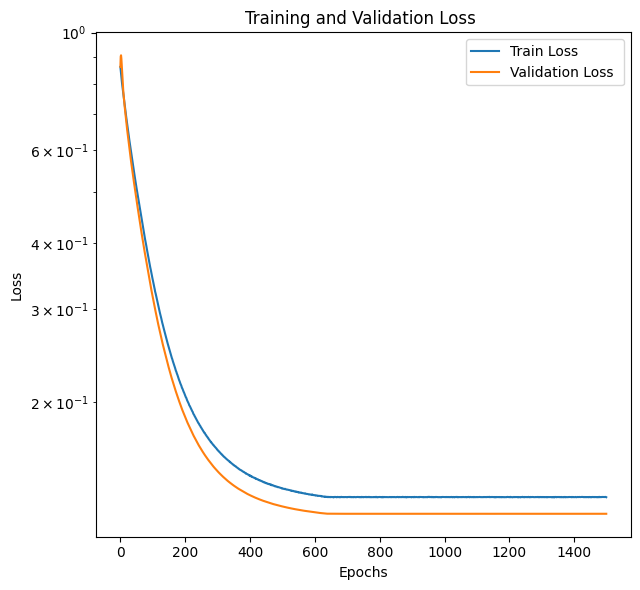

In [20]:


# Print the available keys in the history
print(history.history.keys())

# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If there are specific losses for x_prob and x_midpoints, extract them
train_loss_x_prob = history.history.get('x_prob_reshape_loss', train_loss)
val_loss_x_prob = history.history.get('val_x_prob_reshape_loss', val_loss)
train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)


# Plot the training and validation losses
plt.figure(figsize=(12, 6))

# Plotting x_prob_reshape loss
plt.subplot(1, 2,1)
plt.plot(train_loss_x_prob, label='Train Loss ')
plt.plot(val_loss_x_prob, label='Validation Loss ')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

# # Plotting x_midpoints_reshape loss
# plt.subplot(1, 2, 2)
# plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
# plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss for x_midpoints_reshape')
# plt.legend()

plt.tight_layout()
plt.show()


In [21]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, {'x_probabilities_reshape':train_probabilities,'x_midpoints_reshape':train_midpoints}))
# # val_dataset = tf.data.Dataset.from_tensor_slices((val_images, {'x_probabilities_reshape':val_probabilities,'x_midpoints_reshape':val_midpoints,}))

# train_dataset = train_dataset.batch(400)
# # val_dataset = dataset.take(val_size)
# # val_dataset = dataset.skip(train_size)
# # val_dataset = val_dataset.batch(400)
# inputs,targets = next(iter(train_dataset))
# # inputs,targets = next(iter(val_dataset))
# output =model.predict(inputs)


val_dataset = tf.data.Dataset.from_tensor_slices((val_images, {'x_probabilities_reshape':val_probabilities,'x_midpoints_reshape':val_midpoints,}))


val_dataset = val_dataset.batch(800)

inputs,targets = next(iter(val_dataset))
output =model.predict(inputs)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   


In [22]:
h = np.random.randint(0,len(output))
output[1][h],targets['x_midpoints_reshape'][h]

(array([[[0.2650873 , 0.4207523 ],
         [0.22887076, 0.5551006 ],
         [0.3205404 , 0.7497054 ]]], dtype=float32),
 <tf.Tensor: shape=(1, 3, 2), dtype=float64, numpy=
 array([[[0.1796875, 0.0390625],
         [0.1953125, 0.4765625],
         [0.3671875, 0.7421875]]])>)

In [23]:
import tensorflow as tf

# r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_midpoints_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[1], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = custom_mse(tensor1, tensor2)
# mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss_fn.numpy())

MSE Loss: 0.0405184134267532


Train dataset

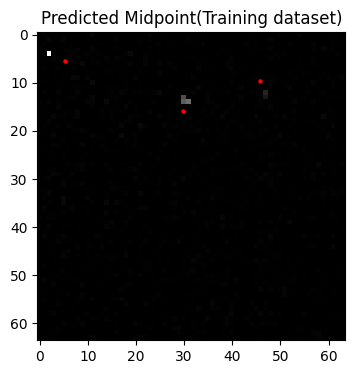

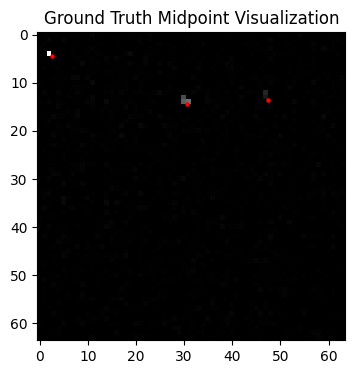

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint(Training dataset)")

    # Plot midpoints based on probability threshold
    for i, (p,u) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(p, u, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()
    
    

t = np.random.randint(0,400)
# t=12
visualize_midpoints(tf.convert_to_tensor(inputs[t]), train_probabilities[t].numpy().squeeze()*64, tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction   
         
            
def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (x,y) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(x, y, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()     
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), train_probabilities[t].numpy().squeeze()*64, tf.convert_to_tensor(targets['x_midpoints_reshape'][t,0,:,:])*[64,64]) ##ground truth
# visualize_midpoints2(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64])          




Validation dataset

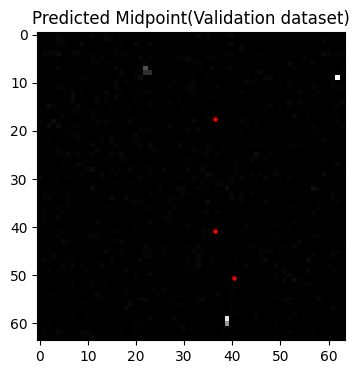

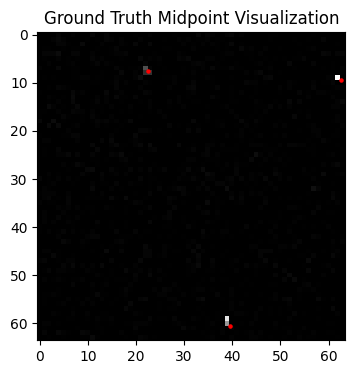

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint(Validation dataset)")

    # Plot midpoints based on probability threshold
    for i, (p,u) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(p, u, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()
    
    

t = np.random.randint(0,400)
# t=12
visualize_midpoints(tf.convert_to_tensor(inputs[t]), output[0][t].squeeze()*64, tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction   
         
            
def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (x,y) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(x, y, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()     
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), targets['x_probabilities_reshape'][t].numpy().squeeze()*64, tf.convert_to_tensor(targets['x_midpoints_reshape'][t,0,:,:])*[64,64]) ##ground truth
# visualize_midpoints2(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64])          




In [88]:
model.save("/home/da886/ElectronCountingProject/Small Building Blocks/Weights from recommendations/moredropouts.h5")